Text(0, 0.5, 'GC(%)')

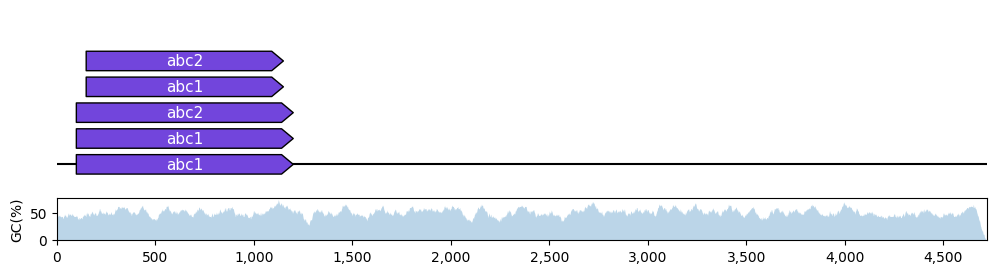

In [5]:
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 3), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

# PLOT THE RECORD MAP
record = SeqIO.read("example_sequence2.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)

# PLOT THE LOCAL GC CONTENT (we use 50bp windows)
gc = lambda s: 100.0 * len([c for c in s if c in "GC"]) / 50
xx = np.arange(len(record.seq))
yy = [gc(record.seq[x : x + 50]) for x in xx]
ax2.fill_between(xx, yy, alpha=0.3)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("GC(%)")

In [3]:
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

In [4]:
import matplotlib as mpl

# 关键配置：SVG 中保留为文本；PDF/PS 嵌入 TrueType 字体
mpl.rcParams['svg.fonttype'] = 'none'   # 文本保留为 <text>
mpl.rcParams['pdf.fonttype'] = 42       # 嵌入 TrueType，AI 可编辑
mpl.rcParams['ps.fonttype']  = 42

# 如果有中文，请指定支持中文的字体（举例：Noto Sans CJK SC / 思源黑体）
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the foll

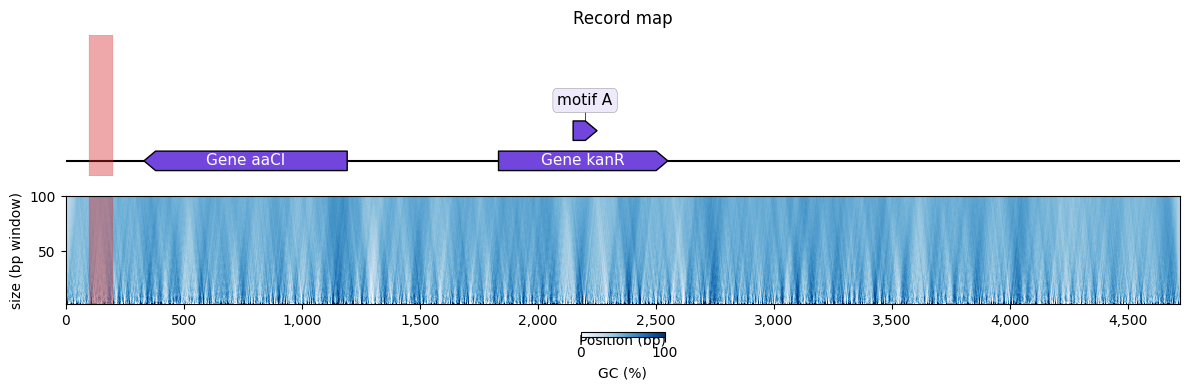

In [7]:


fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 4), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
)

# 1) 注释图
record = SeqIO.read("example_sequence2.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)
ax1.set_title("Record map", fontsize=12, pad=8)

########## 下面这部分替换成自己的数据
# 2) x=序列位置, y=size(2..100) 的热图
seq_str = str(record.seq)
seq_len = len(seq_str)

# 把序列转为 G/C=1, 其它=0 的向量（提高计算效率）
seq_arr = np.frombuffer(seq_str.encode("ascii"), dtype="S1")
is_gc = np.isin(seq_arr, [b"G", b"g", b"C", b"c"]).astype(float)

def rolling_gc_centered(is_gc_vec: np.ndarray, window: int) -> np.ndarray:
    """返回与序列等长的 GC% 曲线（居中窗口）。"""
    if window < 1:
        raise ValueError("window 必须 >= 1")
    k = np.ones(window, dtype=float) / window
    # same 模式保持和序列同长；结果是 [0,1]，乘 100 变成百分比
    return np.convolve(is_gc_vec, k, mode="same") * 100.0

# 准备 size 轴：2..100（包含 2 和 100）
sizes = np.arange(2, 101, dtype=int)

# 生成矩阵：每一行对应一个 size，在每个碱基位置都有一个值
heatmap_data = np.vstack([rolling_gc_centered(is_gc, w) for w in sizes])  # (n_sizes, seq_len)
##########


# 画热图：extent 确保与上方 DNA 注释图按 bp 对齐
im = ax2.imshow(
    heatmap_data,
    aspect="auto",
    origin="lower",
    extent=[0, seq_len, sizes[0]-0.5, sizes[-1]+0.5],  # x:[0,seq_len], y:[1.5,100.5]
    interpolation="nearest",
	cmap=plt.cm.Blues  #plt.cm.coolwarm 
)
ax2.set_xlim(0, seq_len)
ax2.set_ylabel("size (bp window)")
ax2.set_xlabel("Position (bp)")

# 在两个子图上都标出高亮区间与中心竖线
for ax in (ax1, ax2):
    # 半透明区间
    ax.axvspan(100, 200, color="tab:red", alpha=0.4, linewidth=0.2)

# 颜色条（默认放右侧，如需放最下面，把 orientation='horizontal' 且 ax=[ax1,ax2]）
cbar = plt.colorbar(im, ax=ax2,orientation='horizontal',fraction=0.03, pad=0.2)
cbar.set_label("GC (%)")


plt.tight_layout()
plt.savefig('./example_sequence2.pdf')
plt.show()


In [37]:
record = SeqIO.read("./transcript_example.gb", "genbank")

识别到的转录本:
  Transcript1: 3个组件
    - 5UTR: 199-299
    - CDS: 299-600
    - 3UTR: 1200-1600
  Transcript2: 3个组件
    - 5UTR: 1499-1549
    - CDS: 1549-1750
    - 3UTR: 1750-1900
  MOTIF: 1个组件
    - A: 1949-2000

布局结果（共2行）:
  第1行: Transcript1, MOTIF
  第2行: Transcript2


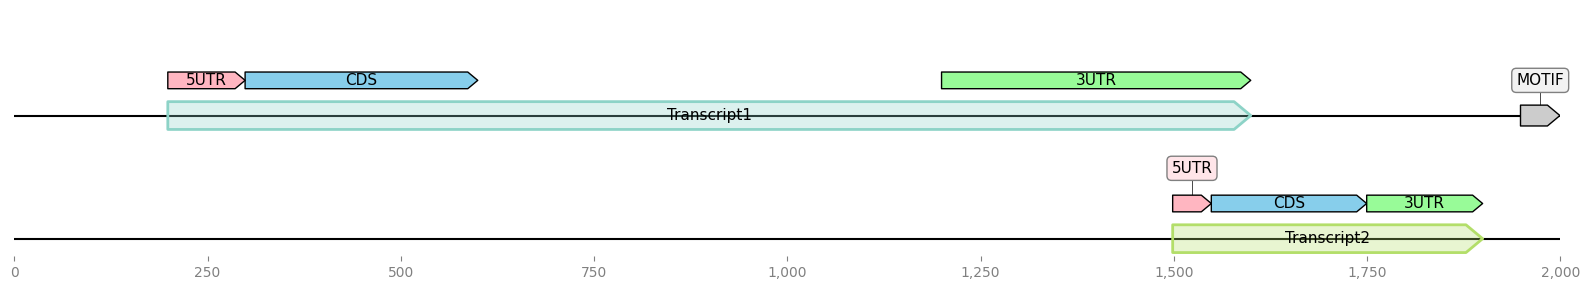

In [41]:
# 基于转录本标签的智能布局可视化
def create_transcript_layout_visualization(record):
    """
    根据label中'-'前的转录本名称分组，
    将不重叠的转录本放在同一行，重叠的转录本放在不同行
    所有特征（包括MOTIF）都参与智能布局，不单独占行
    """
    
    # 1. 解析所有特征，按转录本/特征分组
    transcripts = {}
    
    for feature in record.features:
        if 'label' in feature.qualifiers:
            label = feature.qualifiers['label'][0]
            if '-' in label:
                transcript_name = label.split('-')[0]  # 取'-'前的部分作为转录本名称
                component_type = label.split('-')[1]   # 取'-'后的部分作为组件类型
                
                if transcript_name not in transcripts:
                    transcripts[transcript_name] = []
                
                transcripts[transcript_name].append({
                    'feature': feature,
                    'component_type': component_type,
                    'start': int(feature.location.start),
                    'end': int(feature.location.end),
                    'strand': feature.location.strand,
                    'label': label
                })
            else:
                # 将没有'-'的特征作为单独的"转录本"处理
                # 这样MOTIF等特征也会参与智能布局
                transcript_name = label  # 直接使用label作为名称
                transcripts[transcript_name] = [{
                    'feature': feature,
                    'component_type': feature.type,  # 使用特征类型作为组件类型
                    'start': int(feature.location.start),
                    'end': int(feature.location.end),
                    'strand': feature.location.strand,
                    'label': label
                }]
    
    print("识别到的转录本:")
    for transcript_name, components in transcripts.items():
        print(f"  {transcript_name}: {len(components)}个组件")
        for comp in components:
            print(f"    - {comp['component_type']}: {comp['start']}-{comp['end']}")
    
    # 2. 计算转录本的整体范围
    transcript_ranges = {}
    for transcript_name, components in transcripts.items():
        starts = [comp['start'] for comp in components]
        ends = [comp['end'] for comp in components]
        transcript_ranges[transcript_name] = {
            'start': min(starts),
            'end': max(ends),
            'components': components
        }
    
    # 3. 智能布局算法：将不重叠的转录本放在同一行
    def transcripts_overlap(t1_range, t2_range):
        """检查两个转录本是否重叠"""
        return not (t1_range['end'] < t2_range['start'] or t2_range['end'] < t1_range['start'])
    
    # 贪心算法分配行
    transcript_rows = []
    transcript_names = list(transcript_ranges.keys())
    
    for transcript_name in transcript_names:
        transcript_range = transcript_ranges[transcript_name]
        
        # 尝试放入现有行
        placed = False
        for row_idx, row in enumerate(transcript_rows):
            # 检查与该行中所有转录本是否重叠
            overlaps = False
            for existing_transcript in row:
                if transcripts_overlap(transcript_range, transcript_ranges[existing_transcript]):
                    overlaps = True
                    break
            
            if not overlaps:
                row.append(transcript_name)
                placed = True
                break
        
        # 如果无法放入现有行，创建新行
        if not placed:
            transcript_rows.append([transcript_name])
    
    print(f"\n布局结果（共{len(transcript_rows)}行）:")
    for i, row in enumerate(transcript_rows):
        print(f"  第{i+1}行: {', '.join(row)}")
    
    # 4. 创建可视化 - 使用更紧凑的布局
    total_rows = len(transcript_rows)
    
    # 计算更紧凑的图形尺寸
    row_height = 1.2  # 减小每行高度
    fig_height = max(total_rows * row_height, 3)  # 最小高度为3
    
    fig, axes = plt.subplots(total_rows, 1, figsize=(16, fig_height), sharex=True)
    if total_rows == 1:
        axes = [axes]
    
    # 调整子图间距，使其更紧凑
    plt.subplots_adjust(hspace=0.3)
    
    # 定义转录本组件的颜色
    component_colors = {
        '5UTR': "#FFB6C1",   # 浅粉色
        'CDS': "#87CEEB",    # 天蓝色
        '3UTR': "#98FB98",   # 浅绿色
        'EXON': "#F0E68C",   # 卡其色
        'INTRON': "#D3D3D3", # 浅灰色
        'MOTIF': "#DDA0DD",  # 浅紫色 - 用于MOTIF特征
        'source': "#F5F5F5"  # 浅灰色 - 用于source特征
    }
    
    # 为每个转录本分配独特的基础颜色
    transcript_base_colors = plt.cm.Set3(np.linspace(0, 1, len(transcript_names)))
    transcript_color_map = dict(zip(transcript_names, transcript_base_colors))
    
    # 5. 绘制每一行的转录本 - 组件显示在转录本框架内部
    for row_idx, transcript_row in enumerate(transcript_rows):
        graphic_features = []
        
        for transcript_name in transcript_row:
            transcript_range = transcript_ranges[transcript_name]
            components = transcript_range['components']
            
            # 判断是否为多组件转录本
            if len(components) > 1:
                # 多组件转录本：先绘制整体框架，然后在框架内绘制组件
                base_color = transcript_color_map[transcript_name]
                
                # 绘制转录本整体框架（有填充的背景）
                background_color = (*base_color[:3], 0.3)  # 添加透明度
                graphic_features.append(GraphicFeature(
                    start=transcript_range['start'],
                    end=transcript_range['end'],
                    strand=components[0]['strand'],
                    color=background_color,  # 有填充
                    linewidth=2,
                    linecolor=base_color,
                    label=f"{transcript_name}",
                    thickness=20
                ))
                
                # 在框架内绘制各个组件（较细，位置稍微偏移以显示在框架内）
                for comp in components:
                    comp_color = component_colors.get(comp['component_type'], "#CCCCCC")
                    
                    graphic_features.append(GraphicFeature(
                        start=comp['start'],
                        end=comp['end'],
                        strand=comp['strand'],
                        color=comp_color,
                        label=f"{comp['component_type']}",
                        thickness=12,  # 较细的组件
                        linewidth=1
                    ))
            else:
                # 单组件特征（如MOTIF）：直接显示
                comp = components[0]
                comp_color = component_colors.get(comp['component_type'], "#CCCCCC")
                
                graphic_features.append(GraphicFeature(
                    start=comp['start'],
                    end=comp['end'],
                    strand=comp['strand'],
                    color=comp_color,
                    label=f"{transcript_name}",
                    thickness=15
                ))
        
        # 创建并绘制图形记录
        graphic_record = GraphicRecord(
            sequence_length=len(record.seq),
            features=graphic_features
        )
        
        graphic_record.plot(ax=axes[row_idx], with_ruler=False)
        
        # 设置行标签 - 使用更紧凑的标签
        row_labels = ', '.join(transcript_row)
        axes[row_idx].set_ylabel(f"{row_labels}", fontsize=9)
        axes[row_idx].set_xlim(0, len(record.seq))
        
        # 减小y轴标签的边距
        axes[row_idx].tick_params(axis='y', labelsize=8)
        axes[row_idx].yaxis.set_label_coords(-0.05, 0.5)
    
    # 6. 在最后一行显示标尺
    if len(transcript_rows) > 0:
        # 在最后一行转录本上添加标尺
        last_ax = axes[-1]
        last_ax.set_xlabel("position (bp)")
        # 重新绘制最后一行，但这次带标尺
        last_transcript_row = transcript_rows[-1]
        graphic_features = []
        
        for transcript_name in last_transcript_row:
            transcript_range = transcript_ranges[transcript_name]
            components = transcript_range['components']
            
            # 判断是否为多组件转录本
            if len(components) > 1:
                # 多组件转录本：先绘制整体框架，然后在框架内绘制组件
                base_color = transcript_color_map[transcript_name]
                
                # 绘制转录本整体框架（有填充的背景）
                background_color = (*base_color[:3], 0.3)  # 添加透明度
                graphic_features.append(GraphicFeature(
                    start=transcript_range['start'],
                    end=transcript_range['end'],
                    strand=components[0]['strand'],
                    color=background_color,  # 有填充
                    linewidth=2,
                    linecolor=base_color,
                    label=f"{transcript_name}",
                    thickness=20
                ))
                
                # 在框架内绘制各个组件
                for comp in components:
                    comp_color = component_colors.get(comp['component_type'], "#CCCCCC")
                    
                    graphic_features.append(GraphicFeature(
                        start=comp['start'],
                        end=comp['end'],
                        strand=comp['strand'],
                        color=comp_color,
                        label=f"{comp['component_type']}",
                        thickness=12,
                        linewidth=1
                    ))
            else:
                # 单组件特征（如MOTIF）：直接显示
                comp = components[0]
                comp_color = component_colors.get(comp['component_type'], "#CCCCCC")
                
                graphic_features.append(GraphicFeature(
                    start=comp['start'],
                    end=comp['end'],
                    strand=comp['strand'],
                    color=comp_color,
                    label=f"{transcript_name}",
                    thickness=15
                ))
        
        # 重新创建并绘制最后一行，这次带标尺
        graphic_record = GraphicRecord(
            sequence_length=len(record.seq),
            features=graphic_features
        )
        
        last_ax.clear()  # 清除之前的绘图
        graphic_record.plot(ax=last_ax, with_ruler=True)
        
        # 重新设置标签
        row_labels = ', '.join(last_transcript_row)
        last_ax.set_ylabel(f"{row_labels}", fontsize=9)
        last_ax.set_xlim(0, len(record.seq))
        last_ax.yaxis.set_label_coords(-0.05, 0.5)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    return fig, transcript_rows

# 创建转录本智能布局可视化
fig3, layout_info = create_transcript_layout_visualization(record)
plt.savefig('./transcript_smart_layout.pdf', dpi=300, bbox_inches='tight')
plt.show()
